In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as rfc
from scipy.ndimage import gaussian_filter
import os
from astropy.io import fits
import matplotlib.dates as mdates
import datetime as dt
from dateutil.parser import parse
import multiprocessing as mp
import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.backend as K

%matplotlib inline

In [3]:
tf.__version__

'2.2.0'

# Generate the training data for the CNN for KBMOD

## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline. These were obtained by searching off-ecliptic trajectories in some Pointing Groups from 010 to 146 in the Lori Allen NEO dataset

In [2]:
full_false = np.load('../data_files/aligned_false_positive_coadds.npy')
real_objects = np.load('../data_files/normed_individual_real.npy')
real_false_positives = np.load('../data_files/normed_individual_real_false_positives.npy')

np.shape(full_false)

(113549, 441)

### Make real dataset

Make some real Gaussians and add noise to use as truth for training. Add them to a background from real images and searched along a trajectory. Add some scatter in the alignment and some variance to the PSF size.

In [3]:
import os
from astropy.io import fits
import matplotlib.dates as mdates
import datetime as dt
from dateutil.parser import parse
import multiprocessing as mp
import pickle

with open('../data_files/PickledPointings.pkl', 'rb') as f:
    Pointing_Groups = pickle.load(f)

# Import the times
times=[[]]*len(Pointing_Groups)
for i,pointing in enumerate(Pointing_Groups):
    times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
    for j in range(len(Pointing_Groups[i]['date_obs'])):
        foo = parse(Pointing_Groups[i]['date_obs'][j])
        times[i][j]= foo.timestamp()
        
def makeSyntheticCoadd(pgccd, doMedian=True, applyMask=False):
    """
    This function generates a synthetic coadd for a given pointing group and ccd.
    It generates a random trajectory along the visits and uses those to get 21x21
    pixel stamps. It puts a gaussian with a semi-random PSF in each stamp, with
    some scatter for the central pixel. It adds a linear offset to the stamps.
    It then returns the median of all the stamps.
    """
    pg_num = pgccd[0]
    ccd = pgccd[1]
    visit_list = Pointing_Groups[pg_num]['visit_id']
    cutout_size = 21 # pixels
    speed_lims = [100,300] # px/day
    ang_lims = [0,np.pi/2] # radians
    time_baseline = (times[pg_num][-1]-times[pg_num][0])/(3600*24) # days
    
    visit_num = len(visit_list)
    
    if ccd==2 or ccd==61:
        return([])
    all_data = []
    median_coadd = []
    good_visit_idx = []
    for i,visit_id in enumerate(visit_list):
        #imagePath = '/epyc/projects2/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
        imagePath = '/epyc/users/smotherh/pointing_groups/Pointing_Group_{:03d}'
        diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
        try:
            hdul = fits.open(diffPath)
            data = hdul[1].data
            if applyMask:
                mask = hdul[2].data
                # Bits 0, 1, and 3 correspond to bad pixels, saturated pixels, and cosmic rays in DECam data
                bad_pixel = np.bitwise_and(np.array(mask).astype(int),(1<<0|1<<1|1<<3))
                data[np.where(bad_pixel)] = 0
            data[np.isnan(data)] = 0
            all_data.append(data)
            good_visit_idx.append(i)
        except:
            continue
    if len(all_data) > 0:
        data_size = np.shape(all_data[0])
    else:
        return(median_coadd)
    for j in range(50):
        current_night_time = -1e9
        # Set a 2 pixel potential velocity offset
        max_x_vel_offset = 4*(0.5-np.random.random())
        max_y_vel_offset = 4*(0.5-np.random.random())
        average_x_offset = 2*(1-2*np.random.random())
        average_y_offset = 2*(1-2*np.random.random())
        pg_object_list = []
        speed = (speed_lims[1]-speed_lims[0]) * np.random.random() + speed_lims[0]
        angle = (ang_lims[1]-ang_lims[0]) * np.random.random() + ang_lims[0]
        vel = [speed*np.cos(angle), speed*np.sin(angle)]
        starting_pixel_xy_max = [data_size[1] - 100 - speed*time_baseline, data_size[0] - 100 - speed*time_baseline]
        start_px = [50+starting_pixel_xy_max[0]*np.random.random(), 50+starting_pixel_xy_max[1]*np.random.random()]
        min_gauss_sigma = 1
        brightness_lims = [100,500]
        #object_brightness = (brightness_lims[1]-brightness_lims[0])*np.random.random() + brightness_lims[0]
        object_brightness = np.random.exponential(scale=brightness_lims[1])+brightness_lims[0]
        for idx,visit_id in enumerate(visit_list[good_visit_idx]):
            i = good_visit_idx[idx]
            if np.abs(times[pg_num][i] - current_night_time)>(3600*12):
                current_night_time = times[pg_num][i]
                avg_night_sigma = min_gauss_sigma+np.random.random()
            net_x_offset = 2*(1-2*np.random.random())+average_x_offset
            net_y_offset = 2*(1-2*np.random.random())+average_y_offset
            # Compute the values of various parameters for this specific stamp.
            # Uses the limits defined above.
            data = np.copy(all_data[idx])
            if len(data)<1:
                continue
            elapsed_time = (times[pg_num][i] - times[pg_num][0])/(3600*24)
            pixel = [start_px[0]+vel[0]*elapsed_time, start_px[1]+vel[1]*elapsed_time]
            min_x = int(pixel[0]-(cutout_size-1)/2)-1
            max_x = int(pixel[0]+(cutout_size-1)/2)
            min_y = int(pixel[1]-(cutout_size-1)/2)-1
            max_y = int(pixel[1]+(cutout_size-1)/2)
            cutout = np.copy(data[min_y:max_y,min_x:max_x])
            cutout[np.isnan(cutout)] = 0
            #cutout -= np.min(cutout)
            #cutout /= np.sum(cutout)
            cutout_edge = (cutout_size-1)/2                                                   
            x = np.linspace(-cutout_edge, cutout_edge, cutout_size)
            y = np.linspace(-cutout_edge, cutout_edge, cutout_size)
            x, y = np.meshgrid(x, y)
            sigma = 0.1*np.random.random()+avg_night_sigma
            gaussian_kernel = (object_brightness * (1/(2*np.pi*sigma*sigma) 
                * np.exp(-((x-net_x_offset-max_x_vel_offset*(i/visit_num))**2/(2*sigma**2) + (y-net_y_offset-max_y_vel_offset*(i/visit_num))**2/(2*sigma**2))))
                * (1+(0.1*(np.random.random(cutout_size*cutout_size).reshape(cutout_size,cutout_size)-0.5)))) # add 3% noise to psf)
            # Add the synthetic object to the background except where pixel
            # values are exactly zero (i.e. have been masked out)
            sim_object = np.copy(cutout)
            sim_object[sim_object!=0] += gaussian_kernel[sim_object!=0]
            pg_object_list.append(sim_object)
        if len(pg_object_list)>0:
            if doMedian:
                median_coadd.append(np.median(pg_object_list, axis=0))
            else:
                median_coadd.append(pg_object_list)
        else:
            continue
    return(median_coadd)

In [4]:
# Test the coadd generation
coadds = makeSyntheticCoadd([23,56],doMedian=True,applyMask=False)

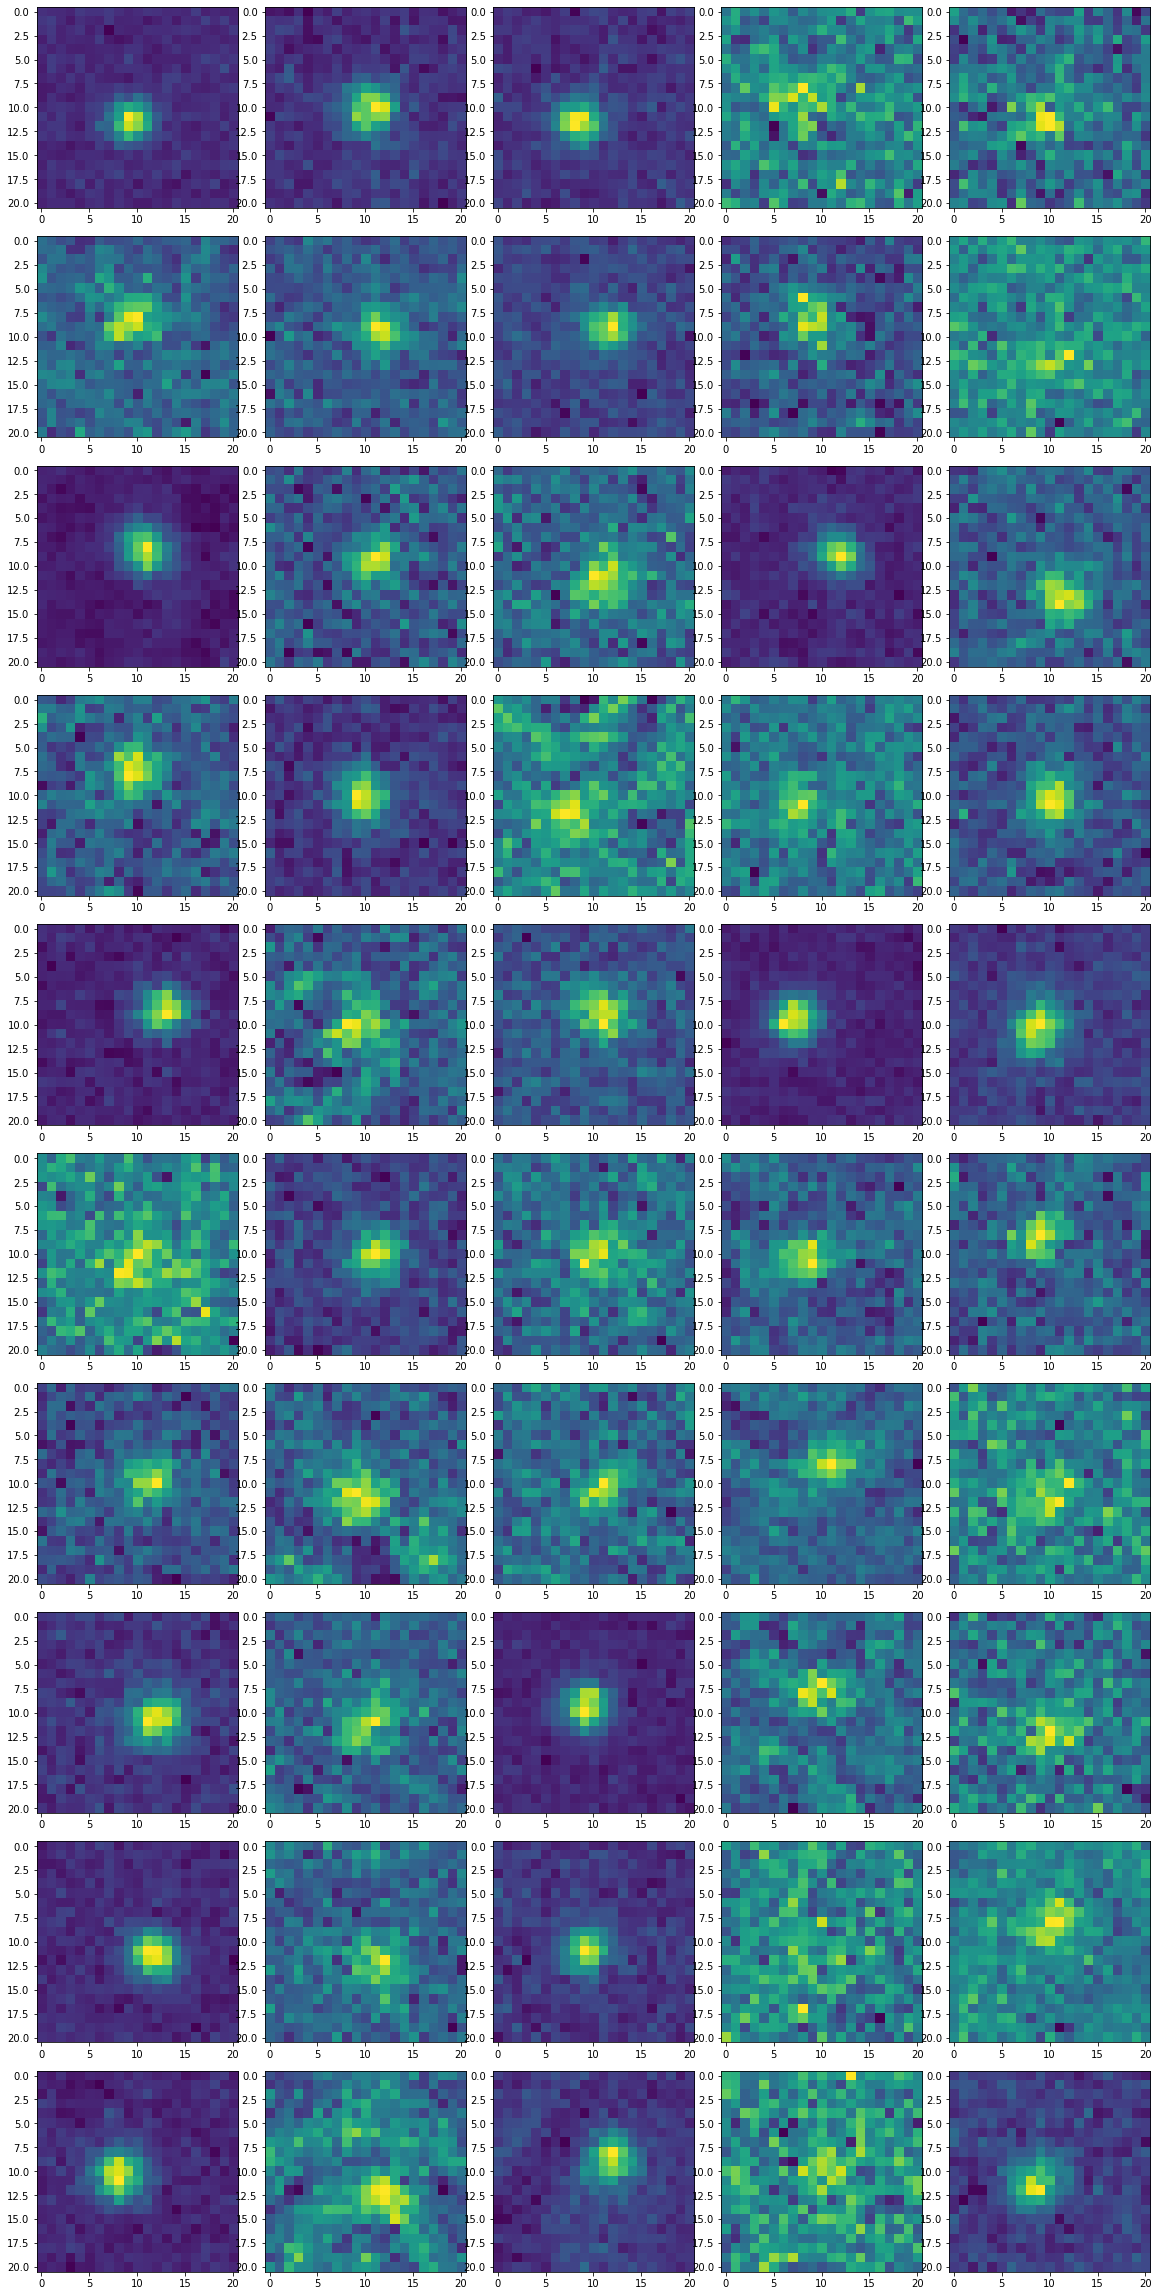

In [5]:
# Plot the test images
fig, ax = plt.subplots(nrows=10,ncols=5,figsize=[16,32])
ax = ax.reshape(-1)
for i,coadd in enumerate(coadds):
    ax[i].imshow(coadd)
plt.tight_layout()

In [172]:
# Generate the full list of simulated stamps using
# the backgrounds from images not in the Search Sample

known_object_pgccd_list = np.loadtxt('/epyc/users/smotherh/pointing_groups/known_object_list.txt').astype(int)

foo = np.linspace(1,62,62).astype(int)
foo = foo[foo!=2]
ccd_list = foo[foo!=61]
pgccd_list = []
for pgccd in known_object_pgccd_list[0:15]:
    for ccd in ccd_list:
        pgccd_list.append([pgccd[0],ccd])
with mp.Pool(10) as pool:
    results = pool.map(makeSyntheticCoadd, pgccd_list)

# Save the stamps
true_coadds = [result for result in results if (len(result)>0)]
true_coadds = np.concatenate(true_coadds,axis=0)
#np.save('simulated_true_coadds_2.npy', true_coadds)

# Normalize then save the false positive and simulated true stamps

In [7]:
import numpy as np
import matplotlib.pyplot as plt

full_false = np.load('../data_files/aligned_false_positive_coadds.npy')
simulated_positives = np.load('../data_files/simulated_true_coadds_2.npy').astype(float)

#fake_positives = []
#false_positives = []
def norm_stamps(stamp_list):
    normed_stamps = []
    sigmaG_coeff =  0.7413
    for stamp in stamp_list:
        stamp = np.copy(stamp)
        stamp[np.isnan(stamp)] = 0
        per25,per50,per75 = np.percentile(stamp,[25,50,75])
        sigmaG = sigmaG_coeff * (per75 - per25)
        stamp[stamp<(per50-2*sigmaG)] = per50-2*sigmaG
        stamp -= np.min(stamp)
        stamp /= np.sum(stamp)
        stamp[np.isnan(stamp)] = 0
        normed_stamps.append(stamp.reshape(21,21))
    normed_stamps = np.array(normed_stamps)
    return(normed_stamps)

false_positives = norm_stamps(full_false)
fake_positives = norm_stamps(simulated_positives)
#real_positives = norm_stamps(real_objects)

/astro/users/smotherh/anaconda3/envs/python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in true_divide


In [178]:
# Save the normed stamps
#np.save('normed_individual_simulated_2.npy',fake_positives)
#np.save('normed_individual_false.npy',false_positives)

## Define the CNN models and helper functions

In [8]:
def plot_true_false(true, false):
    fig_0,ax_0 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    fig_1,ax_1 = plt.subplots(nrows=2,ncols=5,figsize=[8,4])
    ax_0 = ax_0.reshape(-1)
    ax_1 = ax_1.reshape(-1)
    true_int_list = np.random.choice(len(true),10,replace=False)
    false_int_list = np.random.choice(len(false),10,replace=False)
    for i, ax in enumerate(ax_0):
        ax.imshow(true[true_int_list[i]].reshape(21,21))
    for i, ax in enumerate(ax_1):
        ax.imshow(false[false_int_list[i]].reshape(21,21))
    fig_0.suptitle('True',fontsize=16)
    fig_1.suptitle('False',fontsize=16)
    fig_0.tight_layout()
    fig_1.tight_layout()

In [9]:
def simple_model(input_shape=(21,21,1), n_classes: int = 2):
    model = tf.keras.models.Sequential(name='simple')
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu', name='fc_1'))
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))
    return(model)

In [10]:

def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):
    """
        VGG6
    :param input_shape:
    :param n_classes:
    :return:
    """

    model = tf.keras.models.Sequential(name='VGG6')
    # input: 21x21 images with 1 channel -> (21, 21, 1) tensors.
    # this applies 16 convolution filters of size 3x3 each.
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, name='conv1'))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', name='conv2'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv3'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', name='conv4'))
    model.add(tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu', name='fc_1'))
    model.add(tf.keras.layers.Dropout(0.5))
    # output layer
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation, name='fc_out'))

    return model

In [11]:
# The Resnet 50 model is the one currently used for kbmod filtering

# Based on https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
K.set_image_data_format('channels_last')
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    
    return X

def ResNet50(input_shape=(21, 21, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=2, block='a', s=1)
    X = identity_block(X, 3, [128, 128, 512], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2,2), name="avg_pool")(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

# Load the true and false data sets

In [13]:
# These are the current datasets used to train the CNN model
# used in KBMOD paper 2

false_positives = np.load('../data_files/normed_individual_false.npy') #False stamps
false_positives[np.isnan(false_positives)] = 0
fake_positives = np.load('../data_files/normed_individual_simulated_2.npy') #True stamps
fake_positives[np.isnan(fake_positives)] = 0
n=40000
false_index = np.random.choice(false_positives.shape[0], n, replace=False)
true_index = np.random.choice(fake_positives.shape[0], n, replace=False)
false_positives = np.copy(false_positives[false_index])
fake_positives = np.copy(fake_positives[true_index])

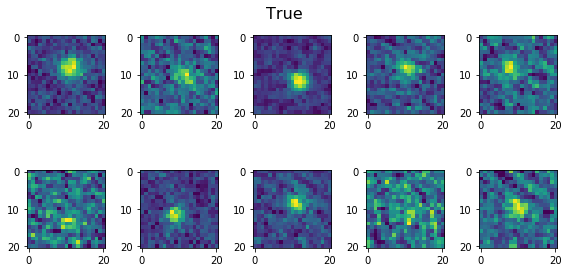

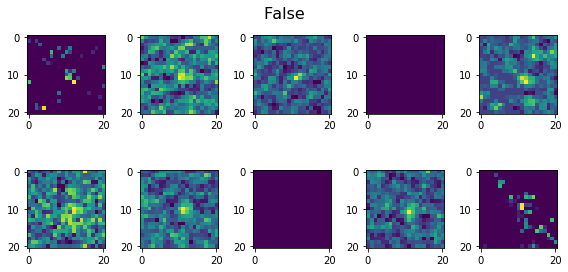

In [14]:
plot_true_false(fake_positives, false_positives)

In [15]:
input_stamps = np.vstack([false_positives, fake_positives])
stamp_class = np.zeros(len(false_positives) + len(fake_positives))
stamp_class[len(false_positives):] = 1

In [16]:
rand_state = np.random.RandomState(32)
idx = rand_state.permutation(len(input_stamps))
input_stamps = input_stamps[idx]
stamp_class = stamp_class[idx]
stamp_class = to_categorical(stamp_class)

In [17]:
train_len = np.int(0.7*len(stamp_class))
val_len = np.int(0.2*len(stamp_class))
test_len = len(stamp_class) - train_len - val_len

train_data = input_stamps[:train_len]
train_class = stamp_class[:train_len]
train_data = train_data.reshape(-1,21,21,1)   #Reshape for CNN -  should work!!
val_data = input_stamps[train_len:train_len+val_len]
val_class = stamp_class[train_len:train_len+val_len]
val_data = val_data.reshape(-1,21,21,1)
test_data = input_stamps[train_len+val_len:]
test_class = stamp_class[train_len+val_len:]
test_data = test_data.reshape(-1,21,21,1)

# Train the CNNs

In [18]:
resnet50_model = ResNet50(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(lr=0.005, momentum=0.05, nesterov=False)
resnet50_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs=20
resnet_model_history = resnet50_model.fit(train_data, train_class, epochs=n_epochs, batch_size=256, verbose=1, validation_data=(val_data, val_class), shuffle=True)


Epoch 1/20
219/219 [==============================] - 11s 51ms/step - loss: 0.2557 - accuracy: 0.8997 - val_loss: 0.9872 - val_accuracy: 0.5006
Epoch 2/20
219/219 [==============================] - 9s 43ms/step - loss: 0.1552 - accuracy: 0.9419 - val_loss: 1.4583 - val_accuracy: 0.5006
Epoch 3/20
219/219 [==============================] - 9s 43ms/step - loss: 0.1271 - accuracy: 0.9543 - val_loss: 0.7054 - val_accuracy: 0.7542
Epoch 4/20
219/219 [==============================] - 9s 43ms/step - loss: 0.1009 - accuracy: 0.9629 - val_loss: 0.4934 - val_accuracy: 0.9468
Epoch 5/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0848 - accuracy: 0.9687 - val_loss: 0.0912 - val_accuracy: 0.9672
Epoch 6/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0794 - accuracy: 0.9717 - val_loss: 0.1077 - val_accuracy: 0.9629
Epoch 7/20
219/219 [==============================] - 10s 44ms/step - loss: 0.0682 - accuracy: 0.9746 - val_loss: 0.0935 - val_accuracy: 0.

In [194]:
simple_cnn = simple_model(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(lr=0.005, momentum=0.05, nesterov=True)
simple_cnn.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs = 20
simple_model_history = simple_cnn.fit(train_data, train_class, epochs=n_epochs, batch_size=512, verbose=1, validation_data=(val_data, val_class), shuffle=True)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 56000 samples, validate on 16000 samples
Epoch 1/20
56000/56000 [==============================] - 6s 103us/sample - loss: 0.6877 - acc: 0.5889 - val_loss: 0.6924 - val_acc: 0.5872
Epoch 2/20
56000/56000 [==============================] - 2s 32us/sample - loss: 0.6834 - acc: 0.6942 - val_loss: 0.6917 - val_acc: 0.7707
Epoch 3/20
56000/56000 [==============================] - 2s 36us/sample - loss: 0.6797 - acc: 0.7391 - val_loss: 0.6899 - val_acc: 0.5597
Epoch 4/20
56000/56000 [==============================] - 2s 38us/sample - loss: 0.6745 - acc: 0.7686 - val_loss: 0.6860 - val_acc: 0.6582
Epoch 5/20
56000/56000 [==============================] - 2s 37us/sample - loss: 0.6693 - acc: 0.7941 - val_loss: 0.6788 - val_acc: 0.8084
Epoch 6/20
56000/56000 [==============================] - 2s 35us/sample - loss: 0.6634 - acc: 0.8167 - val_loss: 0.6683 - val_acc: 0.8713


In [62]:
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 19, 19, 8)         1808      
_________________________________________________________________
bn1 (BatchNormalization)     (None, 19, 19, 8)         32        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 8)           0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 9, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 648)               0         
_________________________________________________________________
fc_1 (Dense)                 (None, 64)                41536     
_________________________________________________________________
fc_out (Dense)               (None, 2)                 130       
Total para

In [16]:
vgg_model = vgg6(input_shape=(21,21,1))
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.0, nesterov=False)
vgg_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
n_epochs=50
vgg_model_history = vgg_model.fit(train_data, train_class, epochs=n_epochs, batch_size=512, verbose=1, validation_data=(val_data, val_class), shuffle=True)

Train on 56000 samples, validate on 16000 samples
Epoch 1/50
56000/56000 [==============================] - 1s 21us/sample - loss: 0.6614 - acc: 0.6661 - val_loss: 0.6932 - val_acc: 0.5006
Epoch 2/50
56000/56000 [==============================] - 1s 12us/sample - loss: 0.6093 - acc: 0.7179 - val_loss: 0.6930 - val_acc: 0.5006
Epoch 3/50
56000/56000 [==============================] - 1s 13us/sample - loss: 0.5619 - acc: 0.7598 - val_loss: 0.6909 - val_acc: 0.5161
Epoch 4/50
56000/56000 [==============================] - 1s 12us/sample - loss: 0.5255 - acc: 0.7852 - val_loss: 0.6717 - val_acc: 0.6351
Epoch 5/50
56000/56000 [==============================] - 1s 12us/sample - loss: 0.4944 - acc: 0.8059 - val_loss: 0.6431 - val_acc: 0.6749
Epoch 6/50
56000/56000 [==============================] - 1s 13us/sample - loss: 0.4645 - acc: 0.8222 - val_loss: 0.5529 - val_acc: 0.7294
Epoch 7/50
56000/56000 [==============================] - 1s 14us/sample - loss: 0.4412 - acc: 0.8342 - val_loss: 0.

In [106]:
vgg_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 19, 19, 16)        160       
_________________________________________________________________
conv2 (Conv2D)               (None, 17, 17, 16)        2320      
_________________________________________________________________
bn1 (BatchNormalizationV1)   (None, 17, 17, 16)        64        
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 8, 8, 16)          0         
_________________________________________________________________
conv3 (Conv2D)               (None, 6, 6, 32)          4640      
_________________________________________________________________
conv4 (Conv2D)               (None, 4, 4, 32)          9248      
__________

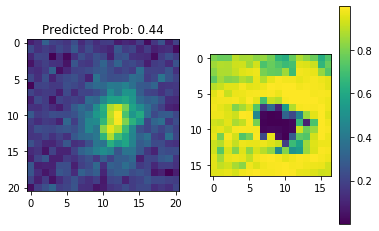

In [18]:
def occlusion_test(input_stamp, model, kernel_size=5):
    i = 0
    j=0
    heatmap = []
    sigmaG_coeff = .7413
    for j in range(22-kernel_size):
        for i in range(22-kernel_size):
            img = np.copy(input_stamp)
            img[i:i+kernel_size,j:j+kernel_size] = 0
            per25,per50,per75 = np.percentile(img,[25,50,75])
            sigmaG = sigmaG_coeff * (per75 - per25)
            img[img<(per50-2*sigmaG)] = per50-2*sigmaG
            img -= np.min(img)
            img /= np.sum(img)
            keras_stamps = np.reshape(img,[-1,21,21,1])
            probs = np.concatenate(model.predict(keras_stamps))
            heatmap.append(probs[1])
    fig = plt.figure()
    unmasked_prob = model.predict(np.reshape(input_stamp,[-1,21,21,1]))[0][1]
    ax1 = fig.add_subplot(121)
    ax1.set_title('Predicted Prob: {:.2f}'.format(unmasked_prob))
    ax1.imshow(input_stamp)
    ax2 = fig.add_subplot(122)
    im = ax2.imshow(np.array(heatmap).reshape(22-kernel_size,22-kernel_size))
    fig.colorbar(im, ax=ax2)
occlusion_test(real_positives[4].reshape(21,21), resnet50_model)

# Save the model

In [185]:
#vgg_model.save('../data_files/vgg_masks.h5')
#resnet50_model.save('../data_files/resnet_2.h5')

# Analyze model results

In [10]:
resnet50_model = tf.keras.models.load_model('../data_files/resnet_2.h5')
#test_model.predict(test_data)
#real_data_probs = test_model.predict(real_positives.reshape(-1,21,21,1))

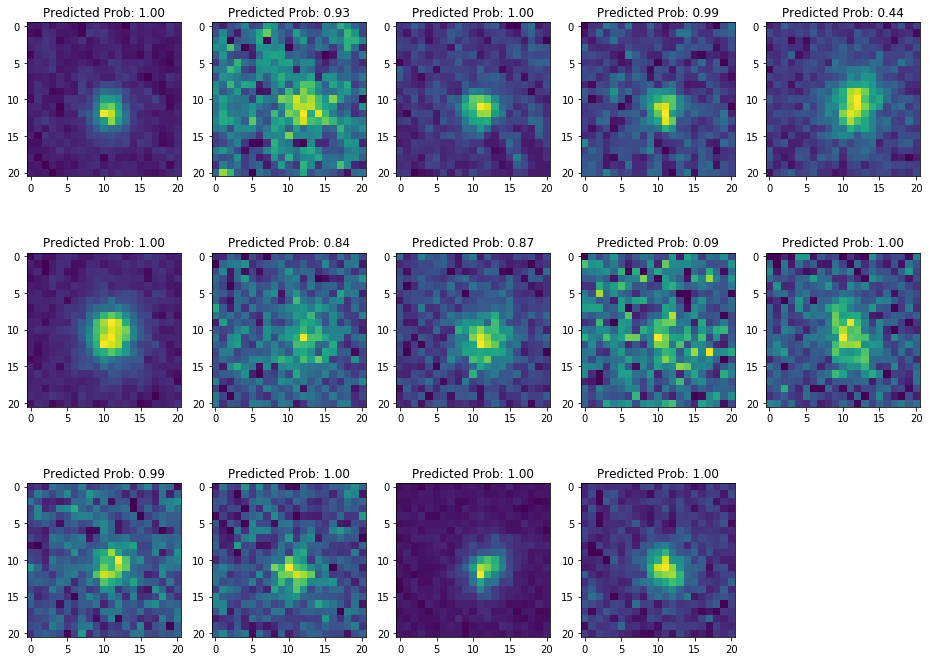

In [19]:
real_positives = real_positives.reshape(-1,21,21,1)
real_data_probs = resnet50_model.predict(real_positives)
fig, ax = plt.subplots(nrows=3,ncols=5,figsize=[16,12])
ax = ax.reshape(-1)
[tmp_ax.set_axis_off() for tmp_ax in ax]
for i,coadd in enumerate(real_positives):
    ax[i].set_axis_on()
    ax[i].imshow(coadd.reshape(21,21))
    ax[i].set_title('Predicted Prob: {:.2f}'.format(real_data_probs[i,1]))


Text(0, 0.5, 'Accuracy')

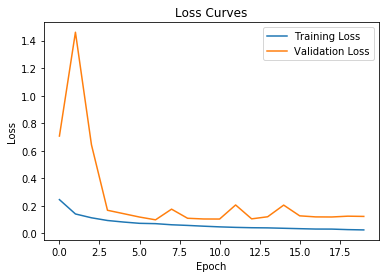

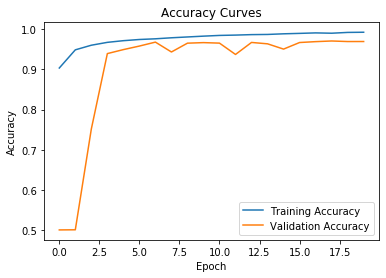

In [198]:
model_history = resnet_model_history
import matplotlib.pyplot as plt
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
plt.figure()
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.savefig('Keras_Loss.png')
plt.figure()
plt.plot(np.arange(n_epochs), acc, label='Training Accuracy')
plt.plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.savefig('figures/ResNet50_LC.png')

Text(0, 0.5, 'Stamp Counts')

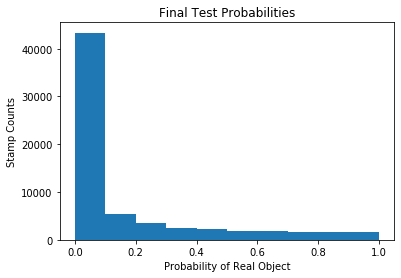

In [26]:
false_positives_classes = resnet50_model.predict(real_false_positives.reshape([-1,21,21,1]))
plt.hist(false_positives_classes[:,1])
plt.title('Final Test Probabilities')
plt.xlabel('Probability of Real Object')
plt.ylabel('Stamp Counts')

In [32]:
foo = false_positives_classes[:,1]
len(foo[foo>0.8])/len(foo)

0.05001601122310496

Text(0, 0.5, 'Stamp Counts')

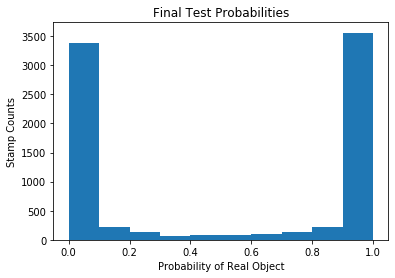

In [15]:
classes = resnet50_model.predict(test_data)
plt.hist(classes[:,1])
plt.title('Final Test Probabilities')
plt.xlabel('Probability of Real Object')
plt.ylabel('Stamp Counts')

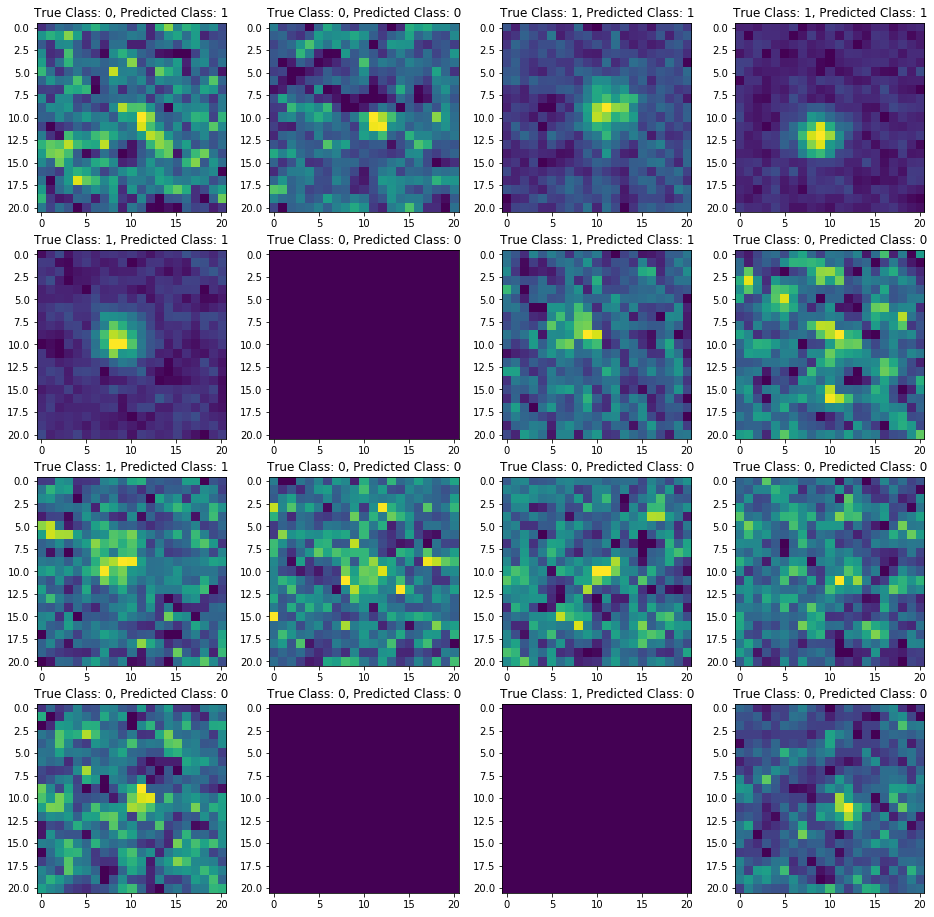

In [204]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(test_data[i].reshape(21,21))
    plt.title('True Class: %i, Predicted Class: %i' % (np.argmax(test_class[i]), np.argmax(classes[i])))

In [16]:
fpr = []
tpr = []
for cutoff in np.arange(0.01, 1.0, 0.01):
    correct_false = []
    correct_true = []
    false_positive = []
    false_negative = []
    index = 0
    for true_class, result_prob in zip(test_class, classes):
        if np.argmax(true_class) == 0.:
            if result_prob[1] < cutoff:
                correct_false.append(index)
            else:
                false_positive.append(index)
        else:
            if result_prob[1] < cutoff:
                false_negative.append(index)
            else:
                correct_true.append(index)
        index+=1
    fpr.append(len(false_positive)/len(np.where(test_class[:,1] == 0)[0]))
    tpr.append(len(correct_true)/len(np.where(test_class[:,1] == 1)[0]))


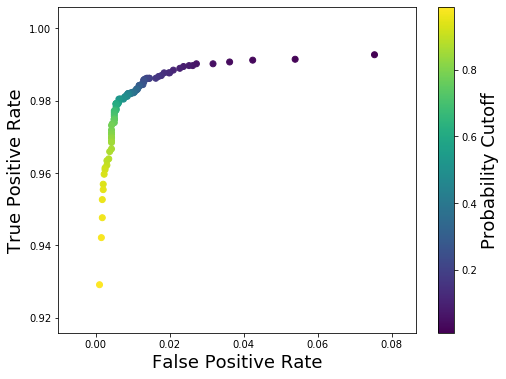

In [26]:
fig = plt.figure(figsize=(8,6))
plt.scatter(fpr, tpr, c=np.arange(0.01, 1.0, 0.01))
cbar = plt.colorbar()
plt.xlabel('False Positive Rate', size=18)
plt.ylabel('True Positive Rate', size=18)
cbar.set_label('Probability Cutoff', size=18)

(2, 0)

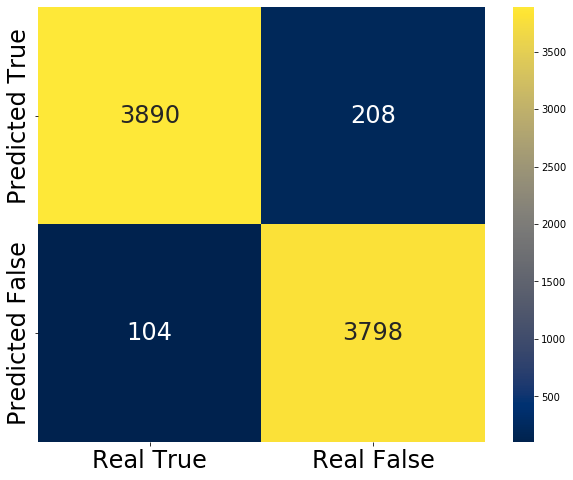

In [17]:
import seaborn as sns
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.5
for true_class, result_prob in zip(test_class, classes):
    if np.argmax(true_class) == 0.:
        if result_prob[1] < cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob[1] < cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1
keras_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])
fig = plt.figure(figsize=(10,8))
sns.heatmap(keras_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')
plt.ylim(2, 0)

In [20]:
print((len(correct_true)+len(correct_false))/np.sum(keras_results))

0.961


3800
194


ValueError: cannot reshape array of size 441 into shape (25,21,21)

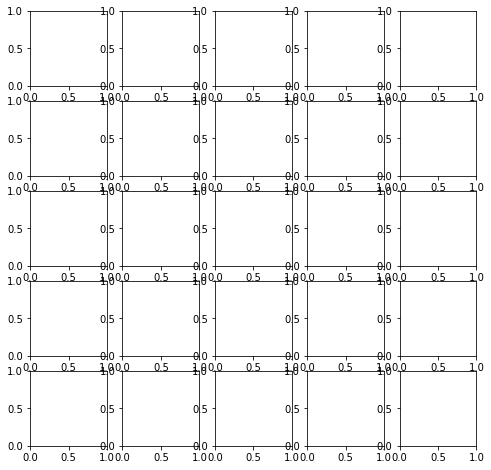

In [30]:
print(len(correct_true))
print(len(false_negative))
def plot_stamps(stamps):
    fig_1,ax_1 = plt.subplots(nrows=5,ncols=5,figsize=[8,8])
    for i,stamp in enumerate(stamps.reshape(25,21,21)):
        j = i%5
        k = int(i/5)
        #print(np.shape(stamp),i)
        ax_1[j][k].imshow(stamp.reshape(21,21))
        
plot_stamps(test_data[false_negative[6]])
plt.tight_layout()

/epyc/opt/anaconda-2019/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


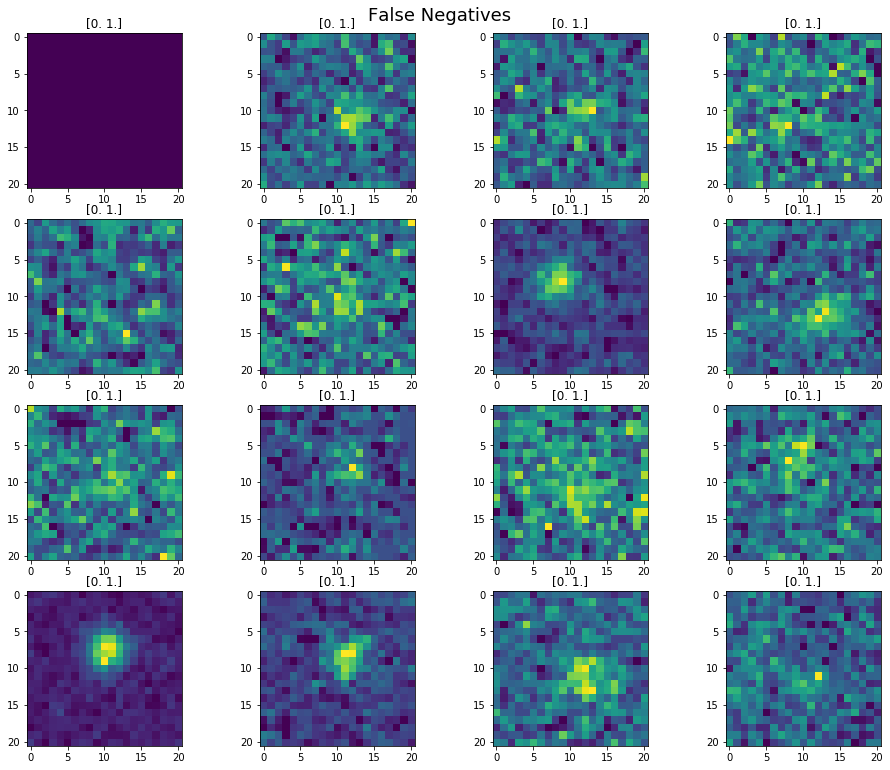

In [202]:
fig = plt.figure(figsize=(16, 12))
for i in range(16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_negative[i]].reshape(21,21))
        plt.title(test_class[false_negative[i]])
    except:
        continue
plt.suptitle('False Negatives', size=18)
plt.subplots_adjust(top=0.95)

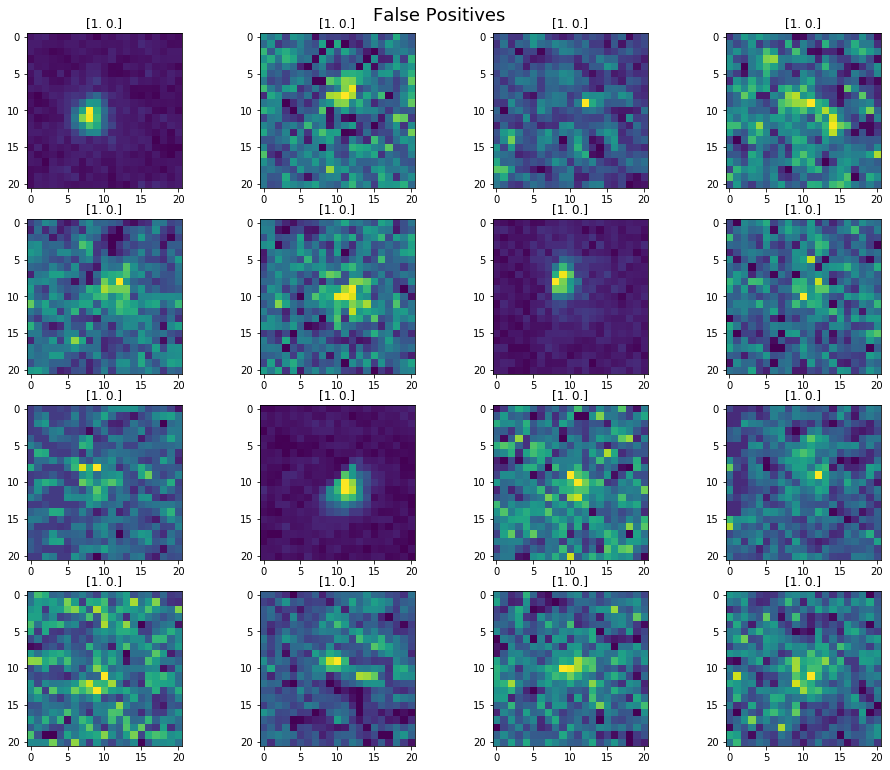

In [203]:
fig = plt.figure(figsize=(16, 12))
for i in r../data_files/16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_positive[i]].reshape(21,21))
        plt.title(test_class[false_positive[i]])
    except:
        continue
plt.suptitle('False Positives', size=18)
plt.subplots_adjust(top=0.95)